### Adapt analyse_output.ipynb code to start regression analysis

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

### (1) Load PDB List

In [2]:
experiment_name = 'dMaSIF_site_1layer_15A_meshpoints_chemfeats'
datafolder = Path(f'preds/{experiment_name}')
pdb_list = [p.stem[:-10] for p in datafolder.glob('*.vtk')]

### (2) Grab mesh point cloud and dMaSIF point cloud
* Focus on the number of points (row vals) of arrays [:,3]
* Also collect min-dists for to address "discrepancy by removing these points from our dataset as well, and only display point-to-point distances in the 99th percentile – i.e. we treat the largest 1% distances as outliers, not displayed here" -- this is from supplemental fig 6

In [3]:
n_meshpoints = []
n_predpoints = []
meshpoints_mindists = []
predpoints_mindists = []
for pdb_id in tqdm(pdb_list):
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))
    n_meshpoints.append(meshpoints.shape[0])
    n_predpoints.append(predpoints.shape[0])
    
    pdists = cdist(meshpoints,predpoints)
    meshpoints_mindists.append(pdists.min(1))
    predpoints_mindists.append(pdists.min(0))

100%|██████████| 2617/2617 [07:00<00:00,  6.23it/s]


In [4]:
print(np.mean(n_predpoints),np.std(n_predpoints))
print(np.mean(n_meshpoints),np.std(n_meshpoints))

7662.935422239205 3200.5129292583956
4303.286969812762 1717.8229665915399


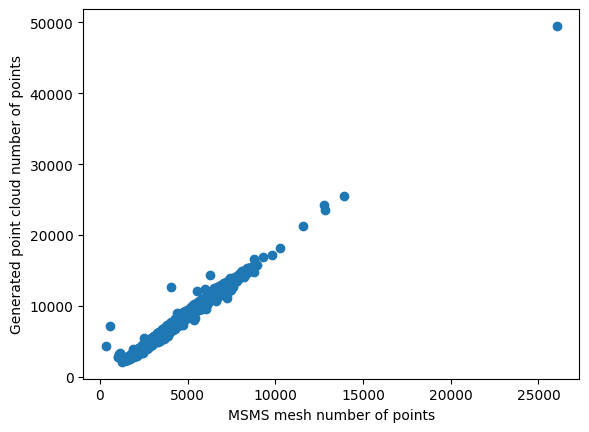

In [5]:
plt.scatter(n_meshpoints,n_predpoints);
plt.xlabel('MSMS mesh number of points');
plt.ylabel('Generated point cloud number of points');

### (3) Map meshpoints to dMaSIF point cloud to map chem_feats from mesh->new point_cloud

In [6]:
# concat list --> np.array

all_meshpoints_mindists = np.concatenate(meshpoints_mindists)
all_predpoints_mindists = np.concatenate(predpoints_mindists)

# define 99% precentile (filter out 1% to remove long pdist tail
meshpoint_percentile = np.percentile(all_meshpoints_mindists,99)
print(meshpoint_percentile)
predpoint_percentile = np.percentile(all_predpoints_mindists,99)
print(predpoint_percentile)

1.9430606313782355
1.1244171465407573


In [7]:
# use the percentile scale values to generate a boolean mask for meshpoints and preppoints

meshpoints_masks = []
predpoints_masks = []

for pdb_id in tqdm(pdb_list):
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))

    pdists = cdist(meshpoints,predpoints)
    meshpoints_masks.append(pdists.min(1)<meshpoint_percentile)
    predpoints_masks.append(pdists.min(0)<predpoint_percentile)

100%|██████████| 2617/2617 [06:58<00:00,  6.25it/s]


### Map predpoints back to meshpoints
* cdist for 2-D distance matrix
* np.argmin(axis=0) to yield idx's for closest meshgrid

In [11]:
all_pred_features = []
all_mesh_features = []

for i, pdb_id in enumerate(tqdm(pdb_list)):
    # load data
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))
    
    # filer data with boolean mask
    predpoints = predpoints[predpoints_masks[i]]
    meshpoints = meshpoints[meshpoints_masks[i]]

    pdists = cdist(meshpoints,predpoints)
    pdist = np.argmin(pdists,axis=0)

    # get predfeatures -- 
    predpoints_features = np.load(datafolder/(pdb_id+'_predfeatures_emb1.npy'))
    predpoints_features = predpoints_features[predpoints_masks[i]]

    meshpoints_features = np.load(datafolder/(pdb_id+'_meshfeatures.npy'))
    meshpoints_features = meshpoints_features[meshpoints_masks[i]]

    all_pred_features.append(predpoints_features)
    all_mesh_features.append(meshpoints_features[pdist])

100%|██████████| 2617/2617 [09:43<00:00,  4.49it/s] 


In [17]:
print(all_pred_features[0].shape[0])
print(all_mesh_features[0].shape[0])

7285
7285


In [20]:
# save files in regression folder for auto-sklearn analysis
outfolder = Path("/home/ubuntu/regress/data")

np.save(outfolder/'all_pred_features.npy', all_pred_features)
np.save(outfolder/'all_mesh_features.npy', all_mesh_features)